In [ ]:
script_path = "/n/home02/amphillips/p26/scripts" # for cannon
import sys
import petar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from astropy.table import Table
from scipy.stats import binned_statistic_2d

import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms

from gala.units import galactic

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D


from tqdm import tqdm


sys.path.append(script_path)
# from analyze_petar import analyze_petar
import PETAR_ANALYSIS_FUNCTIONS as paf
import astropy.constants as const
from streamframe import StreamFrame
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt
plt.style.use(script_path+'/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from scipy.stats import binom

import io

/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [ ]:
paths = paf.define_paths()
simcolm_colors, hm_colors, simcolors = paf.define_simcolors()
time_cmap = paf.define_time_cmap()

init_displacements = paf.define_init_displacements()
apocenters = paf.define_apocenters()

dissolution_times, plotting_times_peri, plotting_times_apo = paf.get_tdis_tplot(paths)

In [3]:
def load_fbin_megaplot_data(paths, init_displacements, apocenters, sim_n,
                            orbit_times, deg_per_bin=5,
                            period_ranges = [np.array([0, 1e100000])*u.yr,np.array([0,1e2])*u.yr,np.array([1e2,1e4])*u.yr,np.array([1e4, 1e100000])*u.yr],
                            countsel=50):
    
    phi1s, phi2s, = [],[] # n x len_phi1/phi2
    phi1_bin_centers = [] # n x [n_bins]
    hline_vals = [] # n x len(period_ranges)
    fbin_vals = [] # n x len(period_ranges) x #bins
    errs_low, errs_up = [], [] # n x len(perio_ranges) x #bins
    selections = []
    for j, n in enumerate(sim_n): # in enumerate(sim_grid):
        
        print("n=%i"%n)
        path = paths[n]
        init_displacement=init_displacements[n]
        i=orbit_times[n]

        if n==10: # separately handle sim 10: output cadence was 10 Myr. 
            i/=10
            i = int(i)

        apo=apocenters[n]

        all_particles, binaries, singles, coords, single_coords, binary_coords = paf.load_coords(path, i, return_all_particles=True,
                                                                                                return_single_particles=True,
                                                                                                use_prog=False,
                                                                                                tdis_estimate = int(i-1), 
                                                                                                init_displacement=init_displacement)
        
        #### THE TRIMMING 
        ##### concatenate single/binaries ? (maybe not necessary lowkey)
        b_phi1, b_phi2, b_r, b_vr = binary_coords['phi1'],binary_coords['phi2'],binary_coords['r'],binary_coords['vr']
        s_phi1, s_phi2, s_r, s_vr = single_coords['phi1'], single_coords['phi2'], single_coords['r'], single_coords['vr']

        all_phi1 = np.concatenate([s_phi1,b_phi1])
        all_phi2 = np.concatenate([s_phi2,b_phi2])
        all_r = np.concatenate([s_r, b_r])
        all_vr = np.concatenate([s_vr, b_vr])

        phi1, phi2, r, vr, in_MW, final_clip = paf.trim_stream_data(all_phi1, all_phi2, all_r, all_vr, apo)
        s_phi1, s_phi2, s_r, s_vr, in_MW_single, final_clip_single = paf.trim_stream_data(s_phi1, s_phi2, s_r, s_vr, apo)
        b_phi1, b_phi2, b_r, b_vr, in_MW_binary, final_clip_binary = paf.trim_stream_data(b_phi1, b_phi2, b_r, b_vr, apo)

        periods = paf.calc_P(binaries.semi * u.pc, binaries.mass * u.Msun).to(u.yr)[in_MW_binary][final_clip_binary]    
        
        _, straight_phi2 = paf.straighten_stream_polynomial(phi1, phi2, show_plot=False)
        phi1s.append(phi1)
        phi2s.append(straight_phi2)

        phimax = np.max(np.abs(phi1))
        bins = np.arange(-phimax, phimax+deg_per_bin, deg_per_bin)
        bin_centers = (bins[:-1]+bins[1:])/2
        phi1_bin_centers.append(bin_centers)
        counts, _, _ = binned_statistic(phi1, phi1, statistic='count', bins=bins)
        sel = counts>countsel
        selections.append(sel)
        binaries_0 = petar.Binary(member_particle_type = petar.Particle, G=petar.G_MSUN_PC_MYR, 
                                  interrupt_mode='bse', external_mode='galpy')
        binaries_0.loadtxt(path+"data.0.binary")
        periods_0 = paf.calc_P(binaries_0.semi*u.pc, binaries_0.mass*u.Msun).to(u.yr)
        singles_0 = petar.Particle(interrupt_mode='bse', external_mode='galpy')
        singles_0.loadtxt(path+'data.0.single')

        # global fbin

        binfracs_this_n = []
        uncs_lower_this_n = []
        uncs_upper_this_n = []

        init_fbins_this_n = []

        for k, period_range in tqdm(enumerate(period_ranges)):
            period_sel = (periods.to(u.yr).value>=period_range[0].to(u.yr).value) & (periods.to(u.yr).value<period_range[1].to(u.yr).value)
            binary_indicator = np.concatenate([
                np.zeros(len(s_phi1)),
                np.zeros(len(b_phi1))
            ])

            phi1_concatenated = np.concatenate([
                s_phi1, 
                b_phi1[period_sel],
                b_phi1[~period_sel]
            ])
            binary_indicator = np.concatenate([
                np.zeros(len(s_phi1)),
                np.ones(len(b_phi1[period_sel])),
                np.zeros(len(b_phi1[~period_sel]))
            ])
            total_counts, _, _ = binned_statistic(phi1_concatenated, binary_indicator, statistic='count',
                                                  bins=bins)
            binary_counts, _, _ = binned_statistic(phi1_concatenated, binary_indicator, statistic='sum', 
                                                   bins=bins)
            binary_fracs = []
            binary_uncs_lower = []
            binary_uncs_upper = []
            for chosenK, N in zip(binary_counts, total_counts):
                p, P = paf.Prob_of_frac(chosenK, N)
                err_low, med, err_up = paf.percentile(p, P)
                binary_fracs.append(med)
                binary_uncs_lower.append(med-err_low)
                binary_uncs_upper.append(err_up-med)


            binfracs_this_n.append(np.array(binary_fracs))
            uncs_lower_this_n.append(np.array(binary_uncs_lower))
            uncs_upper_this_n.append(np.array(binary_uncs_upper))

            # get the initial binary fraction in this range
            period_sel_0 = (periods_0.to(u.yr).value>=period_range[0].to(u.yr).value) & (periods_0.to(u.yr).value<period_range[1].to(u.yr).value)
            binary_indicator_0 = np.concatenate([
                np.zeros(len(singles_0.mass)),
                np.ones(len(periods_0[period_sel_0])),
                np.zeros(len(periods_0[~period_sel_0]))
            ])
            initial_fbin = np.mean(binary_indicator_0)
            init_fbins_this_n.append(initial_fbin)

        hline_vals.append(init_fbins_this_n)
        fbin_vals.append(binfracs_this_n)
        errs_low.append(uncs_lower_this_n)
        errs_up.append(uncs_upper_this_n)

    return phi1s, phi2s, phi1_bin_centers, fbin_vals, errs_low, errs_up, hline_vals, selections

In [ ]:

sim_n = np.arange(0, 24, 1).astype(int)


# phi1s, phi2s, phi1_bin_centers, fbin_vals, errs_low, errs_up, hline_vals, selections = load_fbin_megaplot_data(
#     paths, 
#     init_displacements, 
#     apocenters, 
#     sim_n, 
#     plotting_times_peri, 
#     deg_per_bin=5, #period_ranges=period_ranges,
#     countsel=50
# )

n=0


4it [00:10,  2.68s/it]


n=1


4it [00:11,  2.83s/it]


n=2


4it [00:09,  2.27s/it]


n=3


4it [00:06,  1.54s/it]


n=4


4it [00:10,  2.68s/it]


n=5


4it [00:03,  1.00it/s]


n=6


4it [00:05,  1.30s/it]


n=7


4it [00:02,  1.64it/s]


n=8


4it [00:12,  3.06s/it]


n=9


4it [00:08,  2.03s/it]


n=10


4it [00:12,  3.05s/it]


n=11


4it [00:05,  1.41s/it]


n=12


4it [00:11,  2.97s/it]


n=13


4it [00:04,  1.02s/it]


n=14


4it [00:07,  1.79s/it]


n=15


4it [00:03,  1.27it/s]


n=16


4it [00:15,  3.93s/it]


n=17


4it [00:07,  1.94s/it]


n=18


4it [00:12,  3.16s/it]


n=19


4it [00:06,  1.71s/it]


n=20


4it [00:07,  1.94s/it]


n=21


4it [00:03,  1.17it/s]


n=22


4it [00:06,  1.62s/it]


n=23


4it [00:03,  1.15it/s]


In [ ]:
import pickle
# big_dict = {"phi1s":phi1s,
#             "phi2s":phi2s,
#             # "period_ranges":period_ranges,
#             "phi1_bin_centers":phi1_bin_centers,
#             "fbin_vals":fbin_vals,
#             "errs_low":errs_low,
#             "errs_up":errs_up,
#             "hline_vals":hline_vals,
#             "selections":selections}

# with open('data_for_fbin_plot_updated_circ_tdis_and_sim10.pkl', 'wb') as f:
#     pickle.dump(big_dict, f)

# # Load later so that I don't have to do all that every time ! haha
with open('data_for_fbin_plot_updated_circ_tdis_and_sim10.pkl', 'rb') as f: 
    loaded = pickle.load(f)
    phi1s, phi2s, phi1_bin_centers, fbin_vals, errs_low, errs_up, hline_vals, selections = loaded['phi1s'], loaded['phi2s'],loaded['phi1_bin_centers'], loaded['fbin_vals'], loaded['errs_low'], loaded['errs_up'], loaded['hline_vals'], loaded['selections']

In [7]:
import matplotlib.patheffects as path_effects

In [8]:
# separate chunk of script to plot the data ! ! ! 
def make_fbin_plot(n_grid, color_scheme, save=False, title=None, xlim=[-100,100],
                    figsize=[25,25],
                    period_ranges=[np.array([0, 1e100000])*u.yr,np.array([0,1e2])*u.yr,np.array([1e2,1e4])*u.yr,np.array([1e4, 1e100000])*u.yr],
                    subset=False, n_plot=None):
    labels = [r"$R_{\rm vir,0}=0.75\ \rm pc$",
              r"$R_{\rm vir,0}=1.5\ \rm pc$",
              r"$R_{\rm vir,0}=3.0\ \rm pc$",
              r"$R_{\rm vir,0}=6.0\ \rm pc$"]


    period_labels = ["All binaries"]
    period_labels+=[r"$\log{P/\rm yr}<%i$"%np.log10(period_ranges[1][1].to(u.yr).value)]
    if len(period_ranges)>2:
        for period_range in period_ranges[2:-1]:
            lo = period_range[0].to(u.yr).value
            up = period_range[1].to(u.yr).value
            period_labels += [r"$%i\leq\log{P/\rm{yr}}<%i$"%(np.log10(lo), np.log10(up))]

    # period_labels+=[]
        period_labels+=[r"$\log{P/\rm yr}\geq %i$"%np.log10(period_ranges[-1][0].to(u.yr).value)]
    
    # else:
    #     period_labels+=
    # period_labels = [r"All binaries",
    #                  r"$\log{P/\rm yr}<2$",
    #                  r"$2\leq\log{P/\rm yr}<4$",
    #                  r"$\log{P/\rm yr}\geq 4$"]

    print(period_labels)

    nsims_per_column = len(n_grid[0])
    fig, axs_grid = plt.subplots(nsims_per_column+len(period_ranges), 
                                len(n_grid), figsize=figsize,
                                sharex=True)

    plt.subplots_adjust(wspace=0.03, hspace=0.05)

    axs_grid = np.array(axs_grid)

    for ii, n_list in enumerate(n_grid):
        column = axs_grid[:,ii]
        if ii!=0:
            for ax in column:
                ax.set_yticklabels([])
        bottom_axs = column[-len(period_ranges):]
        for jj, n in enumerate(n_list):
            if subset==True:
                if n not in n_plot:
                    continue
            phi1 = phi1s[n]
            phi2 = phi2s[n]
            column[jj].scatter(phi1, phi2, s=.1, c=color_scheme[jj], rasterized=True)
            column[jj].set_ylim(-1.2,1.2)
            column[jj].set_xlim(*xlim)
            txt = column[jj].text(0.05, 0.8, labels[jj], transform=column[jj].transAxes,
                            # color=color_scheme[jj])
                            color='k', fontsize=25)
            # txt.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
            bin_centers = phi1_bin_centers[n]


            fbins = fbin_vals[n]
            lerrs = errs_low[n]
            uerrs = errs_up[n]
            init_fbins = hline_vals[n]
            sel = selections[n]
            for kk, ax in enumerate(bottom_axs):
                ax.errorbar(bin_centers[sel], fbins[kk][sel], 
                            yerr=[lerrs[kk][sel], uerrs[kk][sel]], color=color_scheme[jj],
                            linewidth=2)
                
                ax.set_ylim(-init_fbins[kk]/10, 2.5*init_fbins[kk])
                if jj==0:
                    ax.axhline(init_fbins[kk], c='k', linewidth=1, linestyle="--")

                    ax.text(0.05, 0.8, period_labels[kk], transform=ax.transAxes)

        if ii==0:   
            for ax in column[:-len(period_ranges)]:
                ax.set_ylabel(r"$\phi_2\ [\degree]$", fontsize=25)
            for ax in bottom_axs:
                ax.set_ylabel(r"$f_{\rm bin}$", fontsize=25)

    for ax in axs_grid[-1]:
        ax.set_xlabel(r"$\phi_1\ [\degree]$", fontsize=25)

    axs_grid[0,0].set_title("Circular Orbits", fontsize=27)
    axs_grid[0,1].set_title("GD-1 Orbits", fontsize=27)
    axs_grid[0,2].set_title("Pal-5 Orbits", fontsize=27)

    if save==True:
        plt.savefig(title, dpi=300, bbox_inches="tight")

    return fig, axs_grid

In [16]:
hline_vals[0]

[np.float64(0.2174336498660823),
 np.float64(0.10453696940183427),
 np.float64(0.08067526986445905),
 np.float64(0.03222141059978898)]

['All binaries', '$\\log{P/\\rm yr}<2$', '$2\\leq\\log{P/\\rm{yr}}<4$', '$\\log{P/\\rm yr}\\geq 4$']


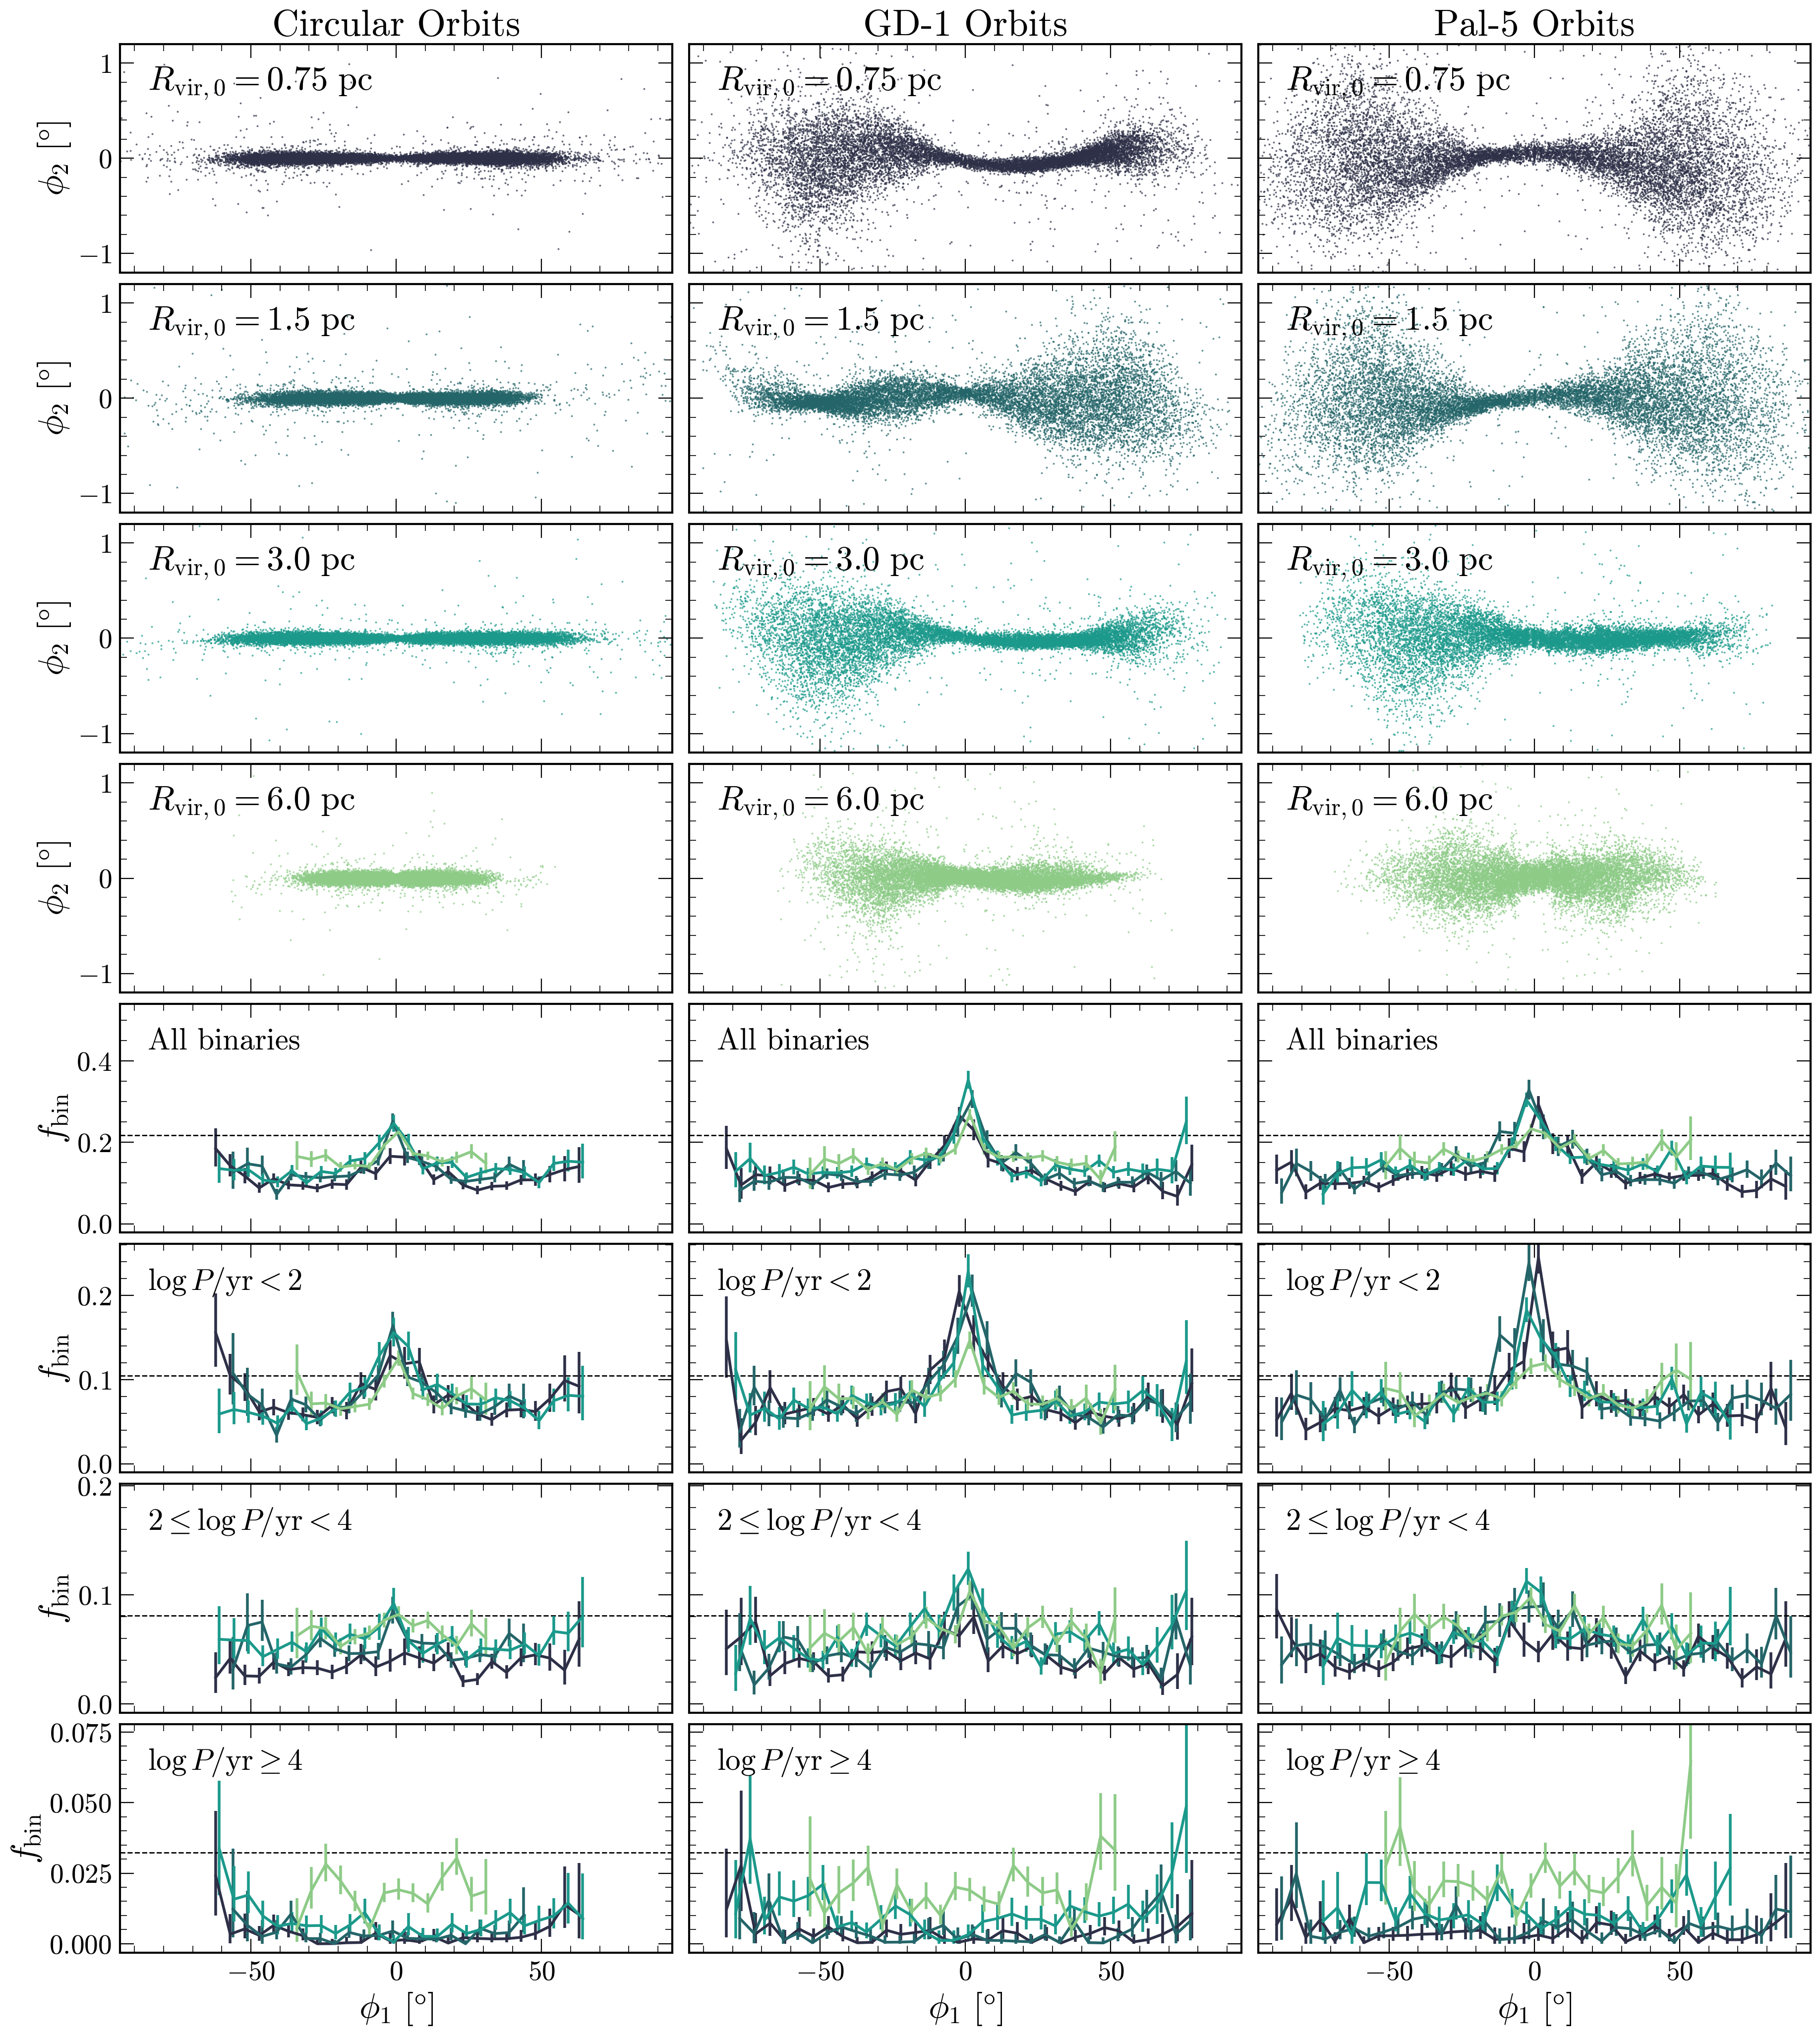

In [10]:
n_grid = [[0,2,4,6],
          [8,10,12,14],
          [16,18,20,22]]
color_scheme = lm_colors
fig, axs_grid = make_fbin_plot(n_grid, lm_colors, save=True, title="plots/fbin_plot_lm.pdf", xlim=[-95,95],
                           #    period_ranges=period_ranges,
                              figsize=[22,25],
                              subset=False, n_plot=[8,14])
# init_fbins = hline_vals[0]
# for kk in range(4):
#    for ax in axs_grid[kk+4]:
#       ax.set_ylim(-init_fbins[kk]/10, 2.5*init_fbins[kk])

['All binaries', '$\\log{P/\\rm yr}<2$', '$2\\leq\\log{P/\\rm{yr}}<4$', '$\\log{P/\\rm yr}\\geq 4$']


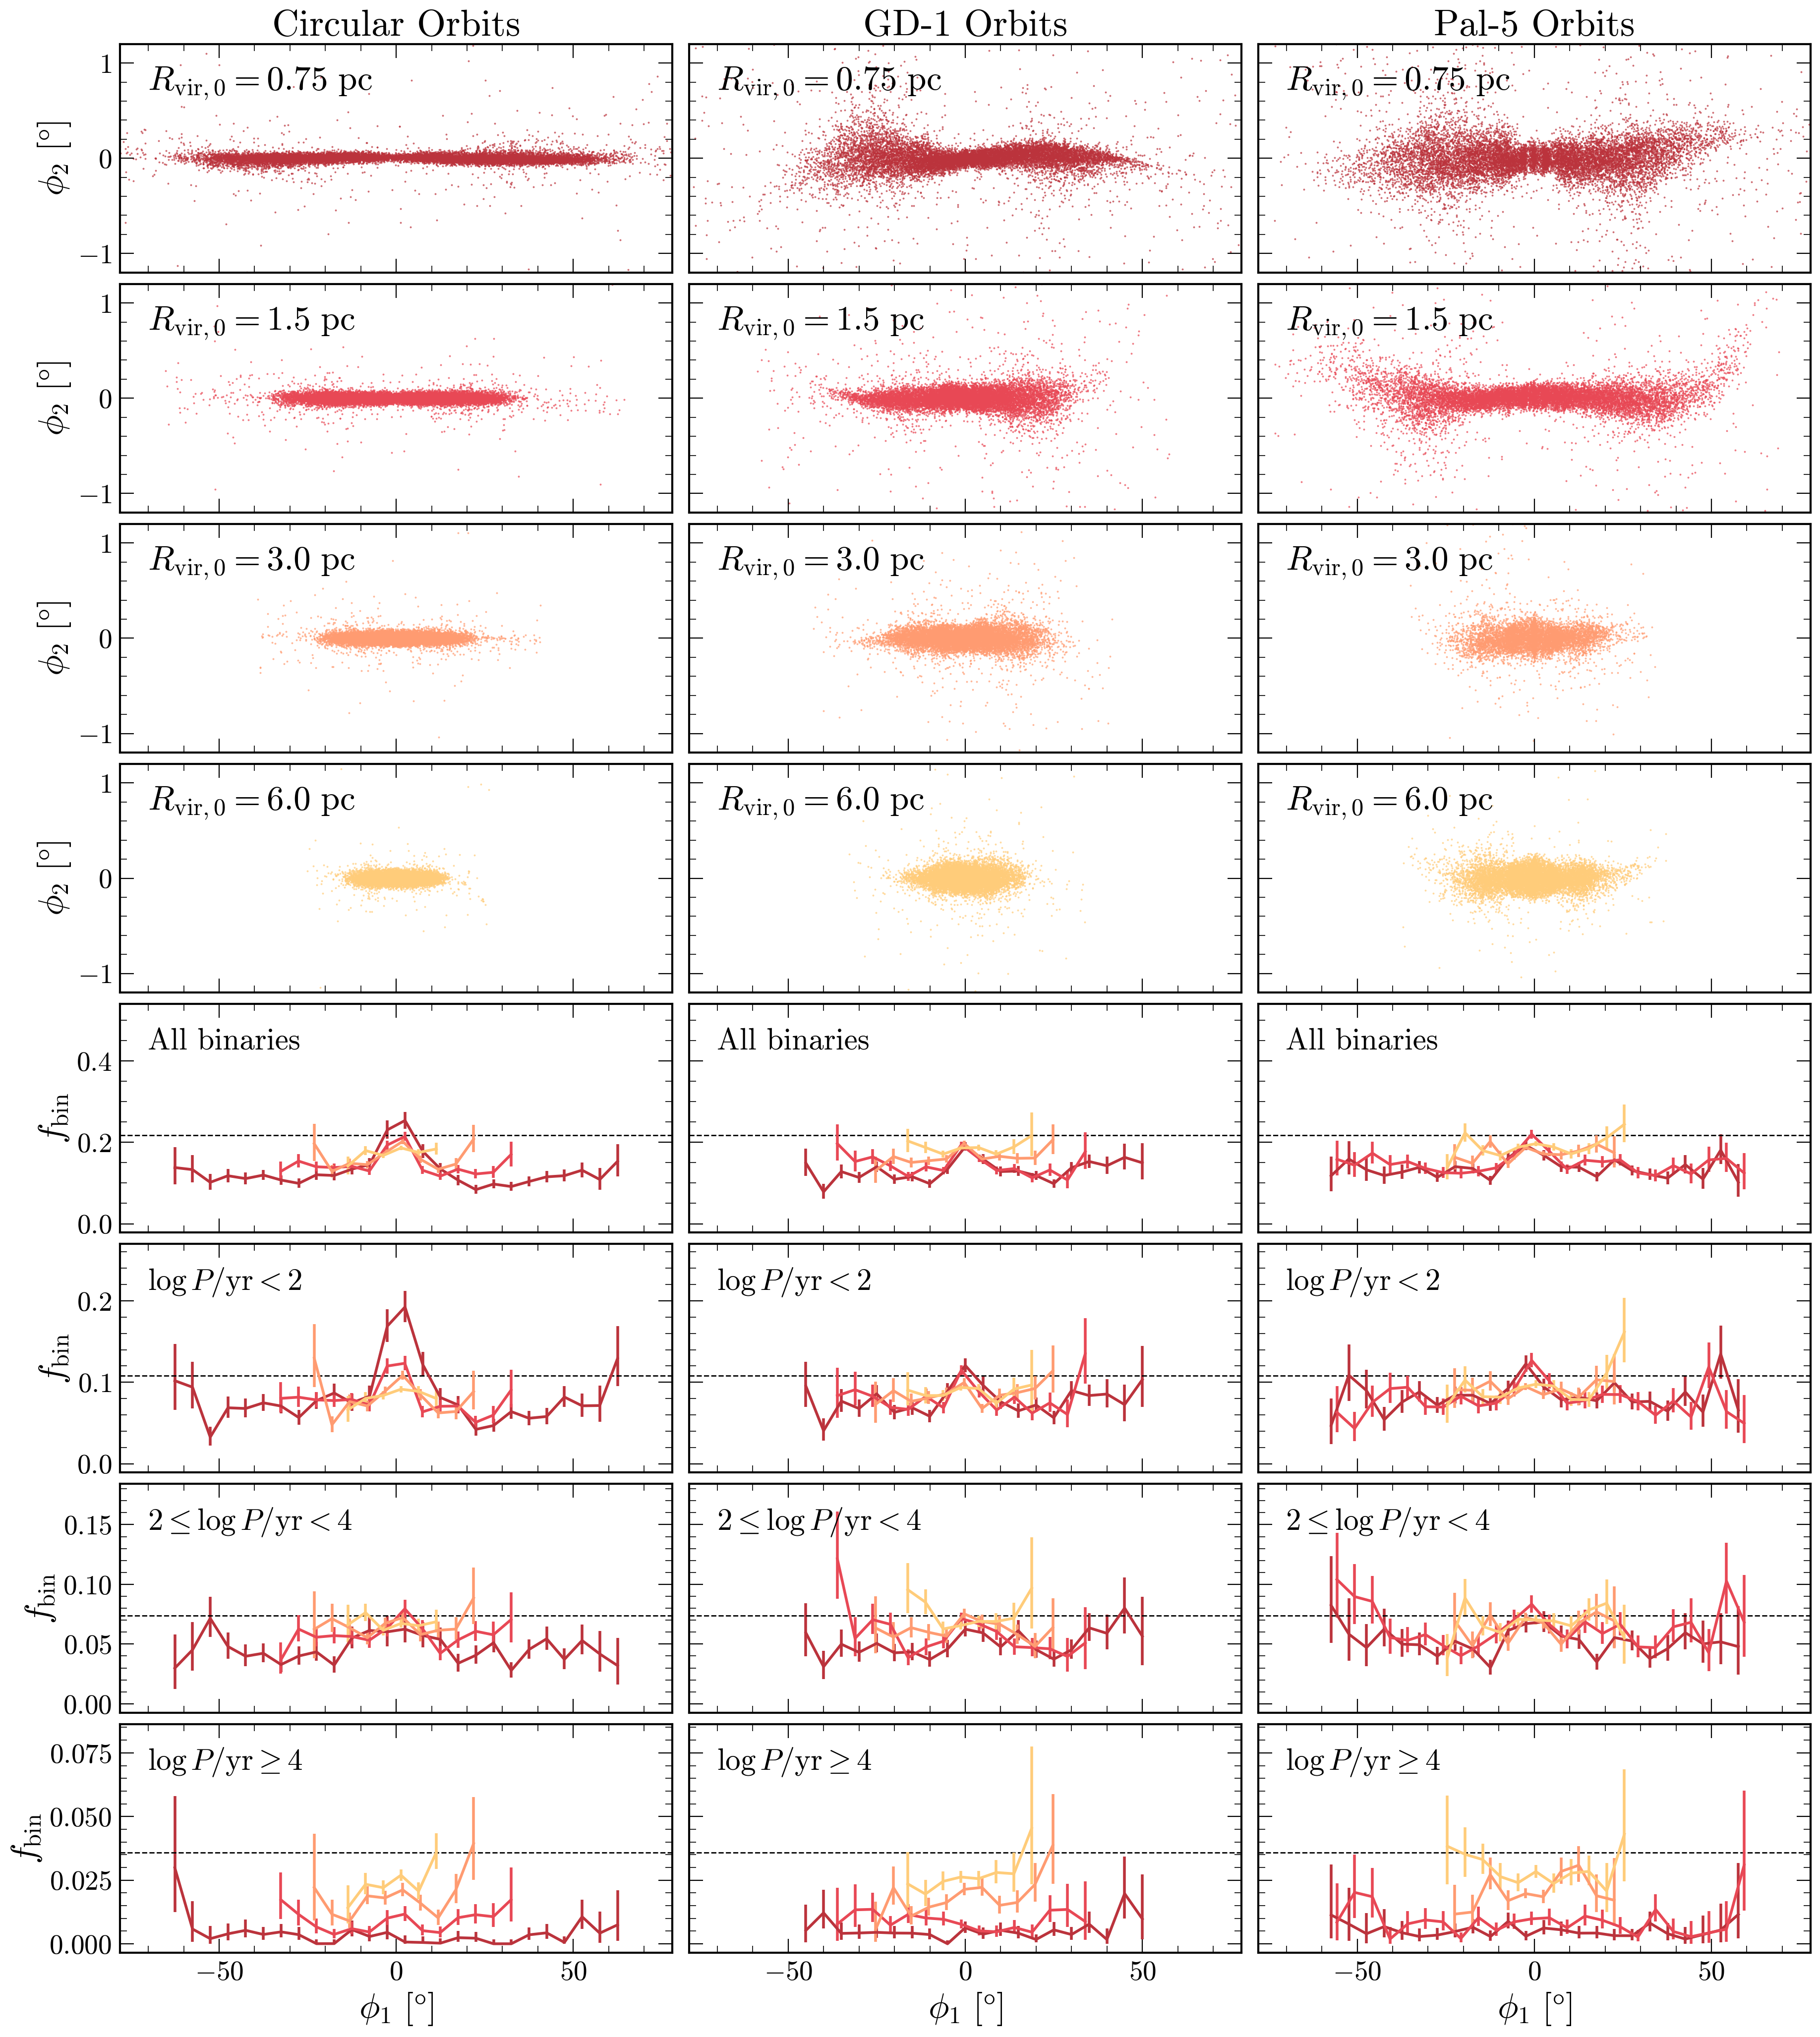

In [23]:
n_grid = [[1,3,5,7],
          [9,11,13,15],
          [17,19,21,23]]
fig, axs = make_fbin_plot(n_grid, hm_colors, save=False, title="plots/fbin_plot_hm.pdf", xlim=[-78,78],
            #    period_ranges=period_ranges,
                 figsize=[22,25])

In [32]:
# Q about mass-segregatey behavior or the circular orbits. 
# new labels?

# sim_inds = [[0,2,4,6],[8,10,12,14],[16,18,20,22]]
sim_inds = [[0,8,16],[1,9,17]]
t_tdis_list = np.linspace(0, 1, 10)
bin_centers, y = paf.load_bound_MF(paths, dissolution_times, sim_inds, t_tdis_list)


constructing column %i
simulation 0


100%|██████████| 10/10 [00:02<00:00,  4.90it/s]


simulation 8


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


simulation 16


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


constructing column %i
simulation 1


100%|██████████| 10/10 [00:02<00:00,  4.78it/s]


simulation 9


100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


simulation 17


100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


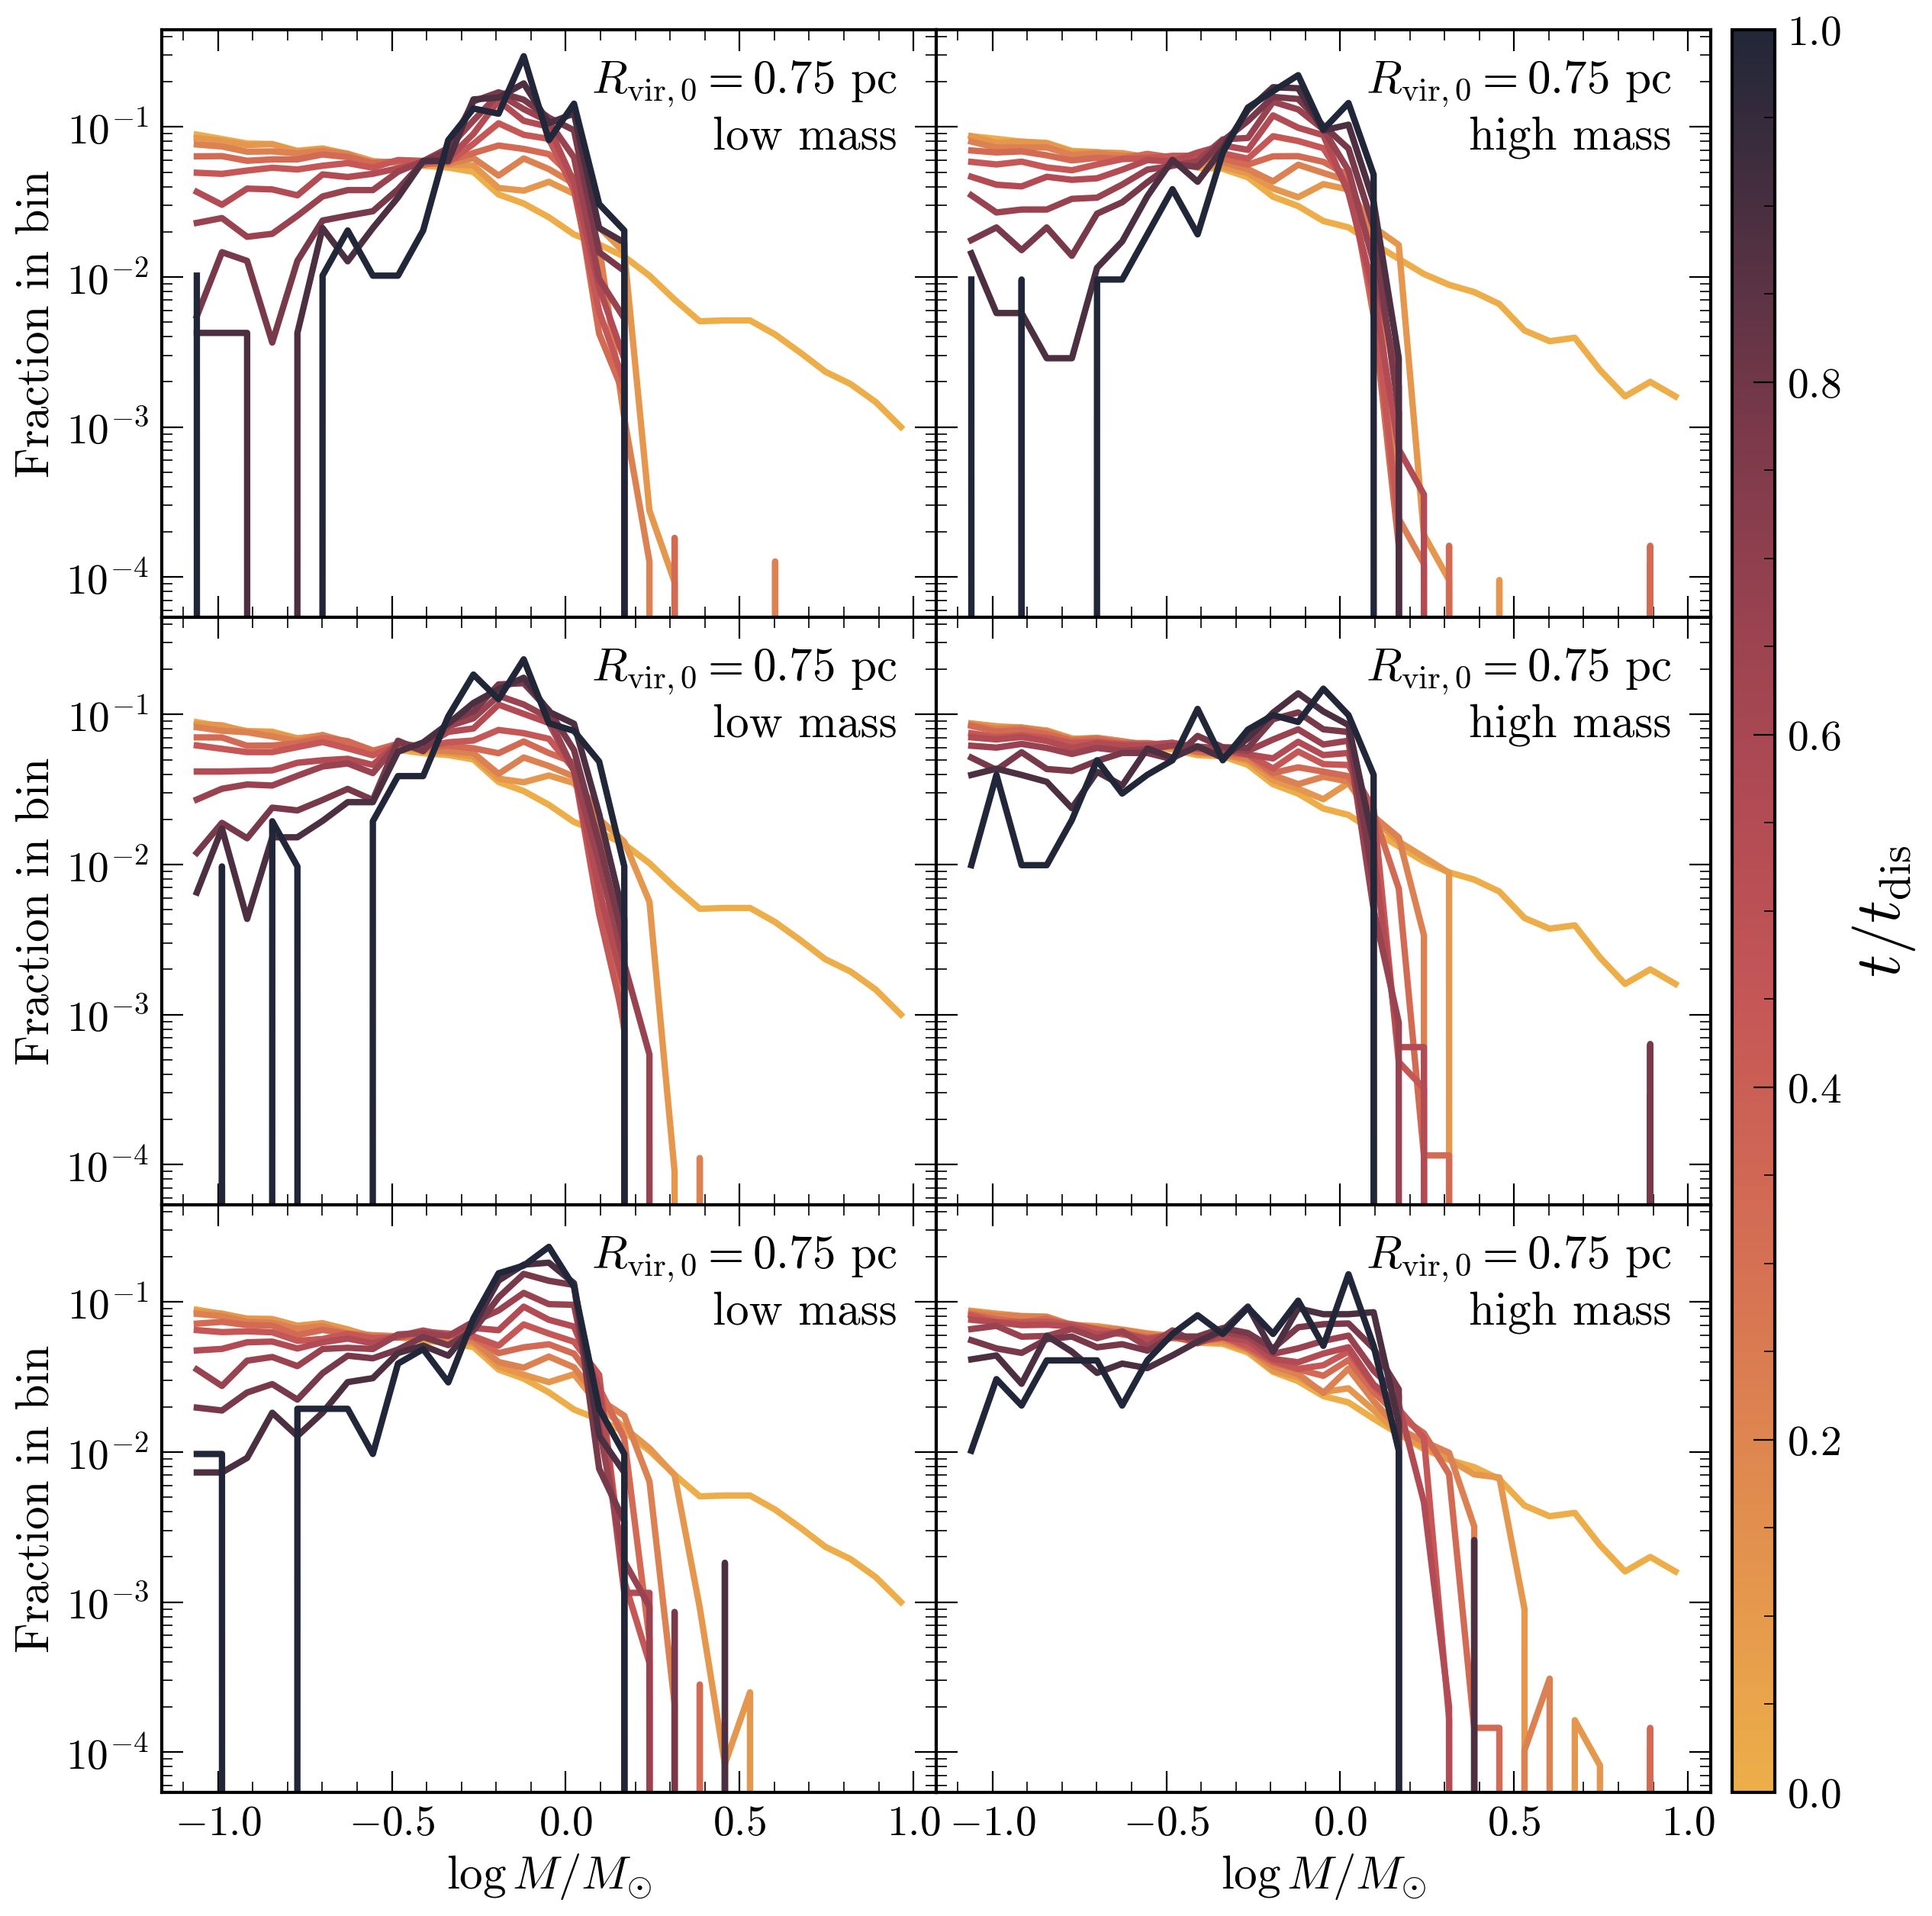

In [34]:
colors=["#212738","#4D3041","#79394A","#994250","#B24B54","#C55756","#D26A54","#DC8051","#E5974D","#EDAE49"]
colors.reverse()
time_cmap = LinearSegmentedColormap.from_list('time_cmap', colors)
plot_labels_new = [
    "$R_{\\rm{vir},0}=0.75$ pc\nlow mass","$R_{\\rm{vir},0}=0.75$ pc\nhigh mass",
    "$R_{\\rm{vir},0}=1.5$ pc\nlow mass","$R_{\\rm{vir},0}=1.5$ pc\nhigh mass",
    "$R_{\\rm{vir},0}=3.0$ pc\nlow mass","$R_{\\rm{vir},0}=3.0$ pc\nhigh mass",
    "$R_{\\rm{vir},0}=6.0$ pc\nlow mass","$R_{\\rm{vir},0}=6.0$ pc\nhigh mass",
] * 3
fig, axs_grid = paf.plot_bound_MF(paths, plot_labels_new, bin_centers, y, sim_inds, t_tdis_list, cmap=time_cmap,
                                  figsize=[14,15], #[20,15],
                                  save=False, title='plots/bound_MF_condensed.pdf')